#Libs and datasets

In [ ]:
!pip install gdown
!pip install orange3

     |████████████████████████████████| 28.6 MB 1.5 MB/s 
     |████████████████████████████████| 491 kB 66.6 MB/s 
     |████████████████████████████████| 1.1 MB 55.2 MB/s 
     |████████████████████████████████| 47 kB 4.4 MB/s 
     |████████████████████████████████| 228 kB 69.2 MB/s 
     |████████████████████████████████| 77 kB 5.2 MB/s 
     |████████████████████████████████| 252 kB 66.8 MB/s 
     |████████████████████████████████| 992 kB 69.9 MB/s 
     |████████████████████████████████| 2.4 MB 47.2 MB/s 
     |████████████████████████████████| 8.3 MB 38.6 MB/s 
     |████████████████████████████████| 149 kB 43.4 MB/s 
     |████████████████████████████████| 58 kB 4.8 MB/s 
     |████████████████████████████████| 54 kB 1.3 MB/s 
     |████████████████████████████████| 79 kB 6.0 MB/s 
     |████████████████████████████████| 51 kB 5.1 MB/s 
     |████████████████████████████████| 59.9 MB 97 kB/s 
     |████████████████████████████████| 338 kB 23.3 MB/s 
     |█████████████████████

In [ ]:
!gdown https://drive.google.com/uc?id=126dO4VNhLpYKT0TKp18RTAGjrHAl_ZpU -O mnist.npz
!gdown https://drive.google.com/uc?id=16wlkaf6GCGX0aJTOtzDo0ypnhqYZ7GVM -O kmnist.npz
!gdown https://drive.google.com/uc?id=1XMH39lcD2bnwy4AW3S-4-0Ge7JIYw6CF -O eurosat.npz
!gdown https://drive.google.com/uc?id=1BsfU84WJMRRKG3wzRZG6KuCperlLrxHc -O cifar10.npz
!gdown https://drive.google.com/uc?id=1MvPjY4m58TW51NZbUIl5tRJbERKMnIk7 -O pathmnist.npz
!gdown https://drive.google.com/uc?id=146WDl2VzVdLhnJl5JqYqKVyDPlDQoLDl -O octmnist.npz
!gdown https://drive.google.com/uc?id=1BIJFOn5ivB766qNIZdI2Owt8GAmpsmic -O organmnist_axial.npz

Downloading...
From: https://drive.google.com/uc?id=126dO4VNhLpYKT0TKp18RTAGjrHAl_ZpU
To: /content/mnist.npz
100% 55.4M/55.4M [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=16wlkaf6GCGX0aJTOtzDo0ypnhqYZ7GVM
To: /content/kmnist.npz
100% 55.4M/55.4M [00:00<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XMH39lcD2bnwy4AW3S-4-0Ge7JIYw6CF
To: /content/eurosat.npz
100% 333M/333M [00:02<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BsfU84WJMRRKG3wzRZG6KuCperlLrxHc
To: /content/cifar10.npz
100% 186M/186M [00:01<00:00, 135MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MvPjY4m58TW51NZbUIl5tRJbERKMnIk7
To: /content/pathmnist.npz
100% 206M/206M [00:01<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=146WDl2VzVdLhnJl5JqYqKVyDPlDQoLDl
To: /content/octmnist.npz
100% 54.9M/54.9M [00:01<00:00, 43.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BIJFOn5ivB766qNIZdI2Owt8GAmpsmic
To: /content/

In [ ]:
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications import InceptionV3, ResNet50V2, EfficientNetB1, DenseNet169
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Lambda, Input
from tensorflow.image import resize
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from Orange.evaluation import compute_CD, graph_ranks
from scipy.stats import friedmanchisquare, rankdata
import numpy as np
import pandas as pd
import tensorflow as tf
import re, os, time, requests
import matplotlib.pyplot as plt

#Configs

In [ ]:
DATASETS = {
    'cifar10': {
        'shape': (32, 32, 3),
        'classes': 10,
        'proposal': '3(Conv BNorm),(Conv ),(Conv BNorm),(MaxPool Dropout),(Flatten),(Fc 1 512 Dropout),(Softmax),(Lr 0.001)',
        'De Lima': 'Conv2D 128 5 tanh , MaxPooling2D 6 same , Dropout 0.2 , Dense 32 , Dense 128 ,',
        'Diniz': '(((conv*1)pool)*3)fc*0',
        'Silva': '(((conv*3)bnorm-pool-dropout)*3)fc*1*256*lr-0.001',
        'Assuncao': 'layer:conv 128 2 1 same relu 0 1 1, layer:conv 256 3 1 same sigmoid 0 0 0, layer:pool-max 5 2 same, layer:conv 64 4 1 same sigmoid 1 1 1, layer:pool-avg 3 1 valid, layer:conv 256 5 1 same relu 0 0 1, layer:fc linear 1024 1, layer:fc linear 128 0, layer:fc relu 512 1, layer:fc sigmoid 128 0, layer:fc softmax, learning:gradient_descent 0.1'
    },
    'mnist': {
        'shape': (28, 28, 1),
        'classes': 10,
        'proposal': '3(Conv BNorm),(Conv ),(Conv BNorm),(MaxPool Dropout),(Flatten),(Fc 1 64 Dropout),(Softmax),(Lr 0.0001)',
        'De Lima': 'Conv2D 16 7 tanh , MaxPooling2D 2 same , Conv2D 32 3 elu , Dropout 0.6 , Dense 64 ,',
        'Diniz': '(((conv*1)pool)*2)fc*0',
        'Silva': '(((conv*2)bnorm-pool-dropout)*2)fc*2*512*lr-0.0001',
        'Assuncao': 'layer:conv 32 2 1 same relu 0 1 1, layer:conv 128 3 1 same linear 0 1 0, layer:pool-max 5 2 same, layer:conv 256 3 1 same linear 1 0 0, layer:pool-max 4 1 valid, layer:conv 256 5 2 valid linear 1 1 1, layer:fc linear 256 1, layer:fc relu 1024 1, layer:fc linear 1024 1, layer:fc linear 256 0, layer:fc linear 2048 1, layer:fc linear 2048 1, layer:fc sigmoid 1024 1, layer:fc softmax, learning:gradient_descent 0.1'
    },
    'eurosat': {
        'shape': (64, 64, 3),
        'classes': 10,
        'proposal': '3(Conv ),(Conv BNorm),(Conv ),(MaxPool Dropout),(Flatten),(Fc 1 128 Dropout),(Softmax),(Lr 0.0001)',
        'De Lima': 'Conv2D 64 3 selu , MaxPooling2D 4 same , Conv2D 64 3 selu ,  MaxPooling2D 6 same ,  AveragePooling2D 4 same , MaxPooling2D 4 same ,  Dropout 0.1 , Dense 32 ,',
        'Diniz': '(((conv*1)pool)*3)fc*2',
        'Silva': '(((conv*3)bnorm-pool-)*3)fc*0*64*lr-0.001',
        'Assuncao': 'layer:conv 32 2 1 same relu 1 1 1, layer:pool-max 4 1 same, layer:conv 128 1 2 same relu 1 0 1, layer:conv 128 5 1 same relu 0 1 1, layer:conv 128 5 2 same relu 1 0 1, layer:pool-max 5 3 valid, layer:pool-avg 2 1 valid, layer:fc sigmoid 128 0, layer:fc sigmoid 1024 1, layer:fc softmax, learning:gradient_descent 0.1'
    },
}
CNNS = ['Proposal', 'Lima et al. (2019)', 'Diniz et al. (2018)', 'Assunção et al. (2018)', 'Silva et al. (2021)', 'ResNet50V2', 'EfficientNetB1', 'InceptionV3', 'DenseNet169']
PAPER_NAME = 'wcci'
NUM_SAMPLES = 20
METRICS_URL = 'https://c50b-2804-954-3da-da00-406a-9e5a-8132-20ac.ngrok.io/api/analysis/'

#Factories

In [ ]:
def load_dataset(dataset_name):

  shape = DATASETS[dataset_name]['shape']
  dataset = np.load('%s.npz' % dataset_name, allow_pickle=True)

  if dataset_name == 'eurosat':
      
    print('eurosat')
    
    train = dataset['train'].tolist()

    train_images, train_labels = train['image'], train['label']

    train_images = train_images.reshape((train_images.shape[0], *shape))
    train_images = train_images.astype("float") / 255.0

    train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
    validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.2, random_state=42)

  elif dataset_name in ['pathmnist', 'octmnist', 'organmnist_axial']:
      
    print('medmnist:', dataset_name)
    
    train_images = dataset['train_images']
    validation_images = dataset['val_images']
    test_images = dataset['test_images']
    train_labels = dataset['train_labels']
    validation_labels = dataset['val_labels']
    test_labels = dataset['test_labels']

    if shape[2] == 1:
      train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
      validation_images = validation_images.reshape((validation_images.shape[0], 28, 28, 1))
      test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

    train_images = train_images.astype("float") / 255.0
    test_images = test_images.astype("float") / 255.0
    validation_images = validation_images.astype("float") / 255.0

  else:
      
    print('outros:', dataset_name)
    
    train = dataset['train'].tolist()
    test = dataset['test'].tolist()

    train_images, test_images, train_labels, test_labels = train['image'], test['image'], train['label'], test['label']

    train_images = train_images.reshape((train_images.shape[0], *shape))
    train_images = train_images.astype("float") / 255.0

    test_images = test_images.reshape((test_images.shape[0], *shape))
    test_images = test_images.astype("float") / 255.0

    validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.2, random_state=42)

  lb = LabelBinarizer()
  train_labels = lb.fit_transform(train_labels)
  validation_labels = lb.transform(validation_labels)
  test_labels = lb.transform(test_labels)

  dataset.close()

  return train_images, train_labels, validation_images, validation_labels, test_images, test_labels

In [ ]:
def f1_score(y_true, y_pred):
  
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
  return f1_val

In [ ]:
def build_assuncao_model(dataset):

    phenotype = DATASETS[dataset]['Assuncao']
    dataset_shape = DATASETS[dataset]['shape']
    dataset_classes = DATASETS[dataset]['classes']

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=dataset_shape))

    learning_rate = None
    parts = phenotype.split(', ')

    for part in parts:

        sections = part.split(' ')

        if 'layer:conv' in part:
            padding = sections[4]
            activation = sections[5]
            num_filters, filter_shape, stride, bias, bnorm, merge = [int(i) for i in re.findall('\d+', part)]
            model.add(layers.Conv2D(num_filters, (filter_shape, filter_shape), strides=(stride, stride), use_bias=bool(bias), activation=activation, padding=padding))
            if bnorm:
                model.add(layers.BatchNormalization())
        elif 'layer:pool' in part:
            padding = sections[3]
            kernel_size, stride = [int(i) for i in re.findall('\d+', part)]
            if 'avg' in part:
                model.add(layers.AveragePooling2D(pool_size=(kernel_size, kernel_size), strides=(stride, stride), padding=padding))
            elif 'max' in part:
                model.add(layers.MaxPooling2D(pool_size=(kernel_size, kernel_size), strides=(stride, stride), padding=padding))
        elif 'layer:fc' in part:
            if 'Flatten' not in ''.join([str(l.__class__) for l in model.layers]):
                model.add(layers.Flatten())
            activation = sections[1]
            if 'softmax' in activation:
                model.add(layers.Dense(dataset_classes, activation=activation))
            else:
                num_units, bias = [int(i) for i in re.findall('\d+', part)]
                model.add(layers.Dense(num_units, activation=activation, use_bias=bool(bias)))
        elif 'learning' in part:
            learning_rate = float(sections[1])

    opt = optimizers.SGD(learning_rate=learning_rate)

    return model, opt

In [ ]:
def build_delima_model(dataset):

    phenotype = DATASETS[dataset]['De Lima']
    dataset_shape = DATASETS[dataset]['shape']
    dataset_classes = DATASETS[dataset]['classes']

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=dataset_shape))

    parts = phenotype.split(',')
    dense_count = 0

    for part in parts:

        part = part.strip()

        if 'Conv2D' in part:

            _, filters, k_size, activation = part.split(' ')
            filters = int(filters)
            k_size = int(k_size)
            model.add(layers.Conv2D(filters, (k_size, k_size), activation=activation))

        elif 'MaxPooling2D' in part:

            _, p_size, padding = part.split(' ')
            p_size = int(p_size)
            model.add(layers.MaxPooling2D(pool_size=(p_size, p_size), padding=padding))

        elif 'AveragePooling2D' in part:

            _, p_size, padding = part.split(' ')
            p_size = int(p_size)
            model.add(layers.AveragePooling2D(pool_size=(p_size, p_size), padding=padding))

        elif 'Dropout' in part:

            _, rate = part.split(' ')
            rate = float(rate)
            model.add(layers.Dropout(rate))

        elif 'Dense' in part:

            _, neurons = part.split(' ')
            neurons = int(neurons)

            if dense_count == 0:
                model.add(layers.Flatten())

            model.add(layers.Dense(neurons))

            dense_count += 1

    model.add(layers.Dense(dataset_classes, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.01)

    return model, opt

In [ ]:
def build_diniz_model(dataset):

    phenotype = DATASETS[dataset]['Diniz']
    dataset_shape = DATASETS[dataset]['shape']
    dataset_classes = DATASETS[dataset]['classes']

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=dataset_shape))

    nconv, npool, nfc = [int(i) for i in re.findall('\d+', phenotype)]
    has_pool = 'pool' in phenotype

    filter_size = 32

    # Pooling
    for i in range(npool):

        # Convolutions
        for j in range(nconv):

            model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same'))

            # Duplicate number of filters for each two convolutions
            if (((i + j) % 2) == 1): filter_size = filter_size * 2

        # Add pooling
        if has_pool:
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))


    model.add(layers.Flatten())

    # fully connected
    for i in range(nfc):
        model.add(layers.Dense(256))
        model.add(layers.Activation('relu'))

    model.add(layers.Dense(dataset_classes, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.01)

    return model, opt

In [ ]:
def build_proposal_model(dataset):

    phenotype = DATASETS[dataset]['proposal']
    dataset_shape = DATASETS[dataset]['shape']
    dataset_classes = DATASETS[dataset]['classes']

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=dataset_shape))

    learning_rate = None
    filter_size = 32
    nconvs = 0

    nblocks = int(phenotype[0])

    for n in range(nblocks):

        for block in phenotype.split(','):

            if 'Conv' in block:

                if nconvs == 2:
                    filter_size *= 2
                    nconvs = 0

                model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same'))

                if 'BNorm' in block:
                    model.add(layers.BatchNormalization())

                nconvs += 1

            if 'MaxPool' in block:
                model.add(layers.MaxPooling2D(pool_size=(2, 2)))

                if 'Dropout' in block:
                    model.add(layers.Dropout(0.25))


    for block in phenotype.split(','):

        if 'Flatten' in block:
            model.add(layers.Flatten())

        if 'Fc' in block:

            nfc, neurons = re.findall('\d+', block)

            for n in range(int(nfc)):
                model.add(layers.Dense(int(neurons)))
                model.add(layers.Activation('relu'))

            if 'Dropout' in block:
                model.add(layers.Dropout(0.5))

        if 'Softmax' in block:
            model.add(layers.Dense(dataset_classes, activation='softmax'))

        if 'Lr' in block:
            args = re.findall('\d+\.\d+', block)
            learning_rate = float(args[0])


    opt = optimizers.Adam(learning_rate=learning_rate)

    return model, opt

In [ ]:
def build_cec21_model(dataset):

    phenotype = DATASETS[dataset]['Silva']
    dataset_shape = DATASETS[dataset]['shape']
    dataset_classes = DATASETS[dataset]['classes']

    nconv, npool, nfc, nfcneuron = [int(i) for i in re.findall('\d+', phenotype.split('lr-')[0])]
    has_dropout = 'dropout' in phenotype
    has_batch_normalization = 'bnorm' in phenotype
    has_pool = 'pool' in phenotype
    learning_rate = float(phenotype.split('lr-')[1])

    # number of filters
    filter_size = 32

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=dataset_shape))

    # Pooling
    for i in range(npool):

        # Convolutions
        for j in range(nconv):

            model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same'))

            # Duplicate number of filters for each two convolutions
            if (((i + j) % 2) == 1): filter_size = filter_size * 2

            # Add batch normalization
            if has_batch_normalization:
                model.add(layers.BatchNormalization())

        # Add pooling
        if has_pool:
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
            # Add dropout
            if has_dropout:
                model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    # fully connected
    for i in range(nfc):
        model.add(layers.Dense(nfcneuron))
        model.add(layers.Activation('relu'))

    if has_dropout:
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(dataset_classes, activation='softmax'))

    opt = optimizers.Adam(learning_rate=learning_rate)

    return model, opt

In [ ]:
def build_cnn_model(dataset, cnn):

  model = None
  # 75x75 eh o tamanho minimo que as redes disponiveis no Keras aceitam.
  img_w = 75
  img_h = 75
  input = Input(shape=DATASETS[dataset]['shape'])
  resized_images = Lambda(lambda image: resize(image, (img_w, img_h)))(input)

  params = {
      'include_top': True, 
      'weights': None, 
      'classes': DATASETS[dataset]['classes'], 
      'input_tensor': resized_images, 
      'input_shape': (img_w, img_h, DATASETS[dataset]['shape'][2])
  }

  if 'Inception' in cnn:
    model = InceptionV3(**params)
  elif 'ResNet' in cnn:
    model = ResNet50V2(**params)
  elif 'EfficientNet' in cnn:
    model = EfficientNetB1(**params)
  elif 'DenseNet' in cnn:
    model = DenseNet169(**params)

  opt = optimizers.Adam(learning_rate=0.001)

  return model, opt

#Train

In [ ]:
def train_model(model, dataset):

  train_images, train_labels, validation_images, \
    validation_labels, test_images, test_labels = load_dataset(dataset)

  batch_size = 128
  epochs = 100

  train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size, drop_remainder=True)
  validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels)).batch(batch_size, drop_remainder=True)

  history = model.fit(train_ds,
          epochs=epochs, 
          validation_data=validation_ds,
          verbose=1)

  loss, accuracy, f1score = model.evaluate(test_images, test_labels, verbose=1)

  print(accuracy, f1score)

  return accuracy, f1score

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.44.78.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.44.78.210:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
for dataset in DATASETS:

  for cnn in CNNS:

    while True:

      r = requests.get(METRICS_URL)
      df = pd.DataFrame.from_records(r.json())

      print('Verificando dataset e cnn:', dataset, cnn)

      total = len(df[(df.paper == PAPER_NAME) & (df.dataset == dataset) & (df.cnn == cnn)])
      remain = NUM_SAMPLES - total

      if remain <= 0:
        break
      else:
        print('Ainda faltam amostras. Montando modelo.')

        with tpu_strategy.scope():
          if 'Proposal' in cnn:
            model, opt = build_proposal_model(dataset)
          elif 'Lima' in cnn:
            model, opt = build_delima_model(dataset)
          elif 'Diniz' in cnn:
            model, opt = build_diniz_model(dataset)
          elif 'Assunção' in cnn:
            model, opt = build_assuncao_model(dataset)
          elif 'Silva' in cnn:
            model, opt = build_cec21_model(dataset)
          else:
            model, opt = build_cnn_model(dataset, cnn)

        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])
        model.summary()

        print('Iniciando treinamento...')

        start_time = time.time()

        accuracy, f1score = train_model(model, dataset)

        end_time = round(time.time() - start_time)

        model_name = '%s-%s.h5' % (dataset, cnn)
        model.save(model_name)
        size = os.path.getsize(model_name)

        data = {
            'paper': PAPER_NAME,
            'dataset': dataset,
            'cnn': cnn,
            'accuracy': accuracy,
            'f1_score': f1score,
            'size': size,
            'num_layers': len(model.layers),
            'num_params': model.count_params(),
            'time': end_time,
        }
          
        print(data)

        try:
          r = requests.post(METRICS_URL, json=data)
        except BaseException as ex:
          print('Requests error:', ex)

Verificando dataset e cnn: cifar10 Proposal
Verificando dataset e cnn: cifar10 Lima et al. (2019)
Verificando dataset e cnn: cifar10 Diniz et al. (2018)
Verificando dataset e cnn: cifar10 Assunção et al. (2018)
Verificando dataset e cnn: cifar10 Silva et al. (2021)
Verificando dataset e cnn: cifar10 ResNet50V2
Verificando dataset e cnn: cifar10 EfficientNetB1
Verificando dataset e cnn: cifar10 InceptionV3
Verificando dataset e cnn: cifar10 DenseNet169
Verificando dataset e cnn: mnist Proposal
Verificando dataset e cnn: mnist Lima et al. (2019)
Verificando dataset e cnn: mnist Diniz et al. (2018)
Verificando dataset e cnn: mnist Assunção et al. (2018)
Verificando dataset e cnn: mnist Silva et al. (2021)
Verificando dataset e cnn: mnist ResNet50V2
Verificando dataset e cnn: mnist EfficientNetB1
Verificando dataset e cnn: mnist InceptionV3
Verificando dataset e cnn: mnist DenseNet169
Verificando dataset e cnn: eurosat Proposal
Verificando dataset e cnn: eurosat Lima et al. (2019)
Verifica

#Analyse

In [ ]:
r = requests.get(METRICS_URL)
 
df = pd.DataFrame.from_records(r.json())
df[['accuracy', 'f1_score']] = df[['accuracy', 'f1_score']].astype(float)
df[['size', 'num_layers', 'num_params', 'time']] = df[['size', 'num_layers', 'num_params', 'time']].astype(float).astype(int)
df['size'] = df['size']/(1024*1024)

df = df[df.paper == 'wcci']
df.loc[df.cnn == 'Silva et al. (2021)', 'cnn'] = 'Silva et al. (2021a)'
df.loc[df.cnn == 'Proposal', 'cnn'] = 'Silva et al. (2021b)'
df.groupby(['paper', 'dataset', 'cnn']).agg([np.mean, np.std])

accuracy            ...     time            
                                          mean       std  ...     mean         std
paper dataset cnn                                         ...                     
wcci  cifar10 Assunção et al. (2018)  0.819700  0.003704  ...  1506.65   72.847552
              DenseNet169             0.835250  0.021124  ...  4080.45  317.033698
              Diniz et al. (2018)     0.591775  0.016621  ...  1063.95   41.872582
              EfficientNetB1          0.762375  0.010429  ...  2479.70   33.905596
              InceptionV3             0.816775  0.013223  ...  2621.85   80.848315
              Lima et al. (2019)      0.639975  0.006439  ...  1033.30   42.062735
              ResNet50V2              0.786125  0.014175  ...  1893.10   47.469547
              Silva et al. (2021a)    0.861950  0.004392  ...  1270.70   31.034955
              Silva et al. (2021b)    0.860575  0.008727  ...  1316.05   35.425942
      eurosat Assunção et al. (2018)  0.947454  0.003973  ...   966.55   16.993729
              DenseNet169             0.938611  0.004218  ...  2221.20   86.987960
              Diniz et al. (2018)     0.682917  0.022447  ...   763.95   22.915118
              EfficientNetB1          0.836528  0.018759  ...  1574.65   40.222114
              InceptionV3             0.937824  0.044639  ...  1569.80   54.011305
              Lima et al. (2019)      0.908981  0.007116  ...   746.70   21.990668
              ResNet50V2              0.912130  0.006663  ...  1261.40   53.754216
              Silva et al. (2021a)    0.942176  0.012658  ...  1019.55   24.452909
              Silva et al. (2021b)    0.948750  0.011225  ...   967.00   22.632069
      mnist   Assunção et al. (2018)  0.995150  0.001040  ...  1261.45   41.231663
              DenseNet169             0.995050  0.001075  ...  4823.65   65.555340
              Diniz et al. (2018)     0.985725  0.001626  ...  1050.35   46.558707
              EfficientNetB1          0.992975  0.001997  ...  3204.80  172.296745
              InceptionV3             0.995275  0.000980  ...  3170.75  144.197553
              Lima et al. (2019)      0.988075  0.002092  ...  1038.80   41.331268
              ResNet50V2              0.994675  0.000693  ...  2412.80  130.293838
              Silva et al. (2021a)    0.993750  0.000925  ...  1194.75   50.831895
              Silva et al. (2021b)    0.995025  0.000850  ...  1281.45   36.469851

[27 rows x 12 columns]

Null hypothesis: The means of the results of two or more algorithms are the same.
Dataset, objective: cifar10 accuracy
	 null hypothesis: rejected
	 p-value: 2.037822779170794e-26
	 ranking: [1.525 6.    1.475 8.    4.55  7.    9.    3.2   4.25 ]
	 names: ['Silva et al. (2021a)', 'ResNet50V2', 'Silva et al. (2021b)', 'Lima et al. (2019)', 'InceptionV3', 'EfficientNetB1', 'Diniz et al. (2018)', 'DenseNet169', 'Assunção et al. (2018)']
	 cd: 2.6861769756803064


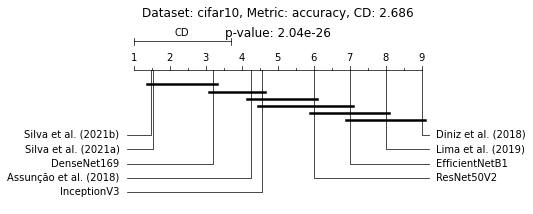

Dataset, objective: cifar10 f1_score
	 null hypothesis: rejected
	 p-value: 1.0235319317282263e-23
	 ranking: [1.45 6.   1.55 8.   4.4  7.   9.   3.2  4.4 ]
	 names: ['Silva et al. (2021a)', 'ResNet50V2', 'Silva et al. (2021b)', 'Lima et al. (2019)', 'InceptionV3', 'EfficientNetB1', 'Diniz et al. (2018)', 'DenseNet169', 'Assunção et al. (2018)']
	 cd: 2.6861769756803064


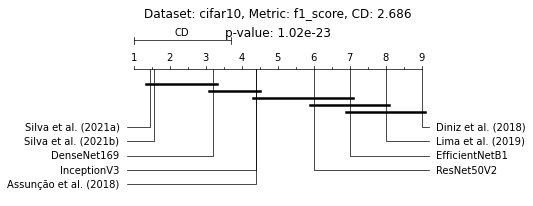

Dataset, objective: mnist accuracy
	 null hypothesis: rejected
	 p-value: 9.419250305629514e-26
	 ranking: [6.175 4.525 3.1   8.    1.975 6.625 9.    3.05  2.55 ]
	 names: ['Silva et al. (2021a)', 'ResNet50V2', 'Silva et al. (2021b)', 'Lima et al. (2019)', 'InceptionV3', 'EfficientNetB1', 'Diniz et al. (2018)', 'DenseNet169', 'Assunção et al. (2018)']
	 cd: 2.6861769756803064


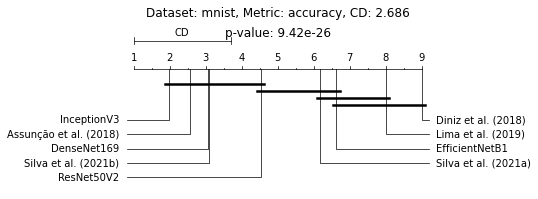

Dataset, objective: mnist f1_score
	 null hypothesis: rejected
	 p-value: 9.871013842379157e-26
	 ranking: [6.175 4.9   2.875 8.    2.275 6.575 9.    3.175 2.025]
	 names: ['Silva et al. (2021a)', 'ResNet50V2', 'Silva et al. (2021b)', 'Lima et al. (2019)', 'InceptionV3', 'EfficientNetB1', 'Diniz et al. (2018)', 'DenseNet169', 'Assunção et al. (2018)']
	 cd: 2.6861769756803064


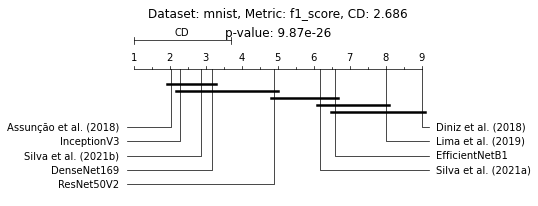

Dataset, objective: eurosat accuracy
	 null hypothesis: rejected
	 p-value: 2.8279439532163626e-26
	 ranking: [3.625 6.05  1.875 6.85  2.5   7.95  9.    4.425 2.725]
	 names: ['Silva et al. (2021a)', 'ResNet50V2', 'Silva et al. (2021b)', 'Lima et al. (2019)', 'InceptionV3', 'EfficientNetB1', 'Diniz et al. (2018)', 'DenseNet169', 'Assunção et al. (2018)']
	 cd: 2.6861769756803064


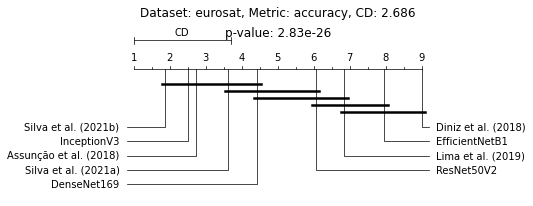

Dataset, objective: eurosat f1_score
	 null hypothesis: rejected
	 p-value: 2.0829349851821633e-25
	 ranking: [3.65 6.05 2.   6.85 2.4  7.95 9.   4.4  2.7 ]
	 names: ['Silva et al. (2021a)', 'ResNet50V2', 'Silva et al. (2021b)', 'Lima et al. (2019)', 'InceptionV3', 'EfficientNetB1', 'Diniz et al. (2018)', 'DenseNet169', 'Assunção et al. (2018)']
	 cd: 2.6861769756803064


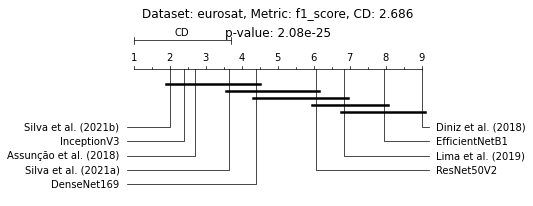

In [ ]:
objectives = ['accuracy', 'f1_score']
alpha = 0.05
 
print('Null hypothesis:', 'The means of the results of two or more algorithms are the same.')

for dataset in DATASETS:
  
  data = df[df.dataset == dataset]
  cnns = data.cnn.unique()
  
  for objective in objectives:
    
    print('Dataset, objective:', dataset, objective)
    
    df1 = pd.DataFrame({cnn: list(data[data.cnn == cnn][objective]) for cnn in cnns})
    values = df1.values
    names = df1.columns    

    friedman = friedmanchisquare(*values)
    ranks = np.array([rankdata(-p) for p in values])
    average_ranks = np.mean(ranks, axis = 0)
    
    cd = compute_CD(average_ranks, n=len(df1), alpha=str(alpha), test='nemenyi')
    
    print('\t', 'null hypothesis:', 'rejected' if friedman.pvalue < alpha else 'accepted')
    print('\t', 'p-value:', friedman.pvalue)
    print('\t', 'ranking:', average_ranks)
    print('\t', 'names:', list(names))
    print('\t', 'cd:', cd)
    
    graph_ranks(average_ranks, names=names, cd=cd)
    # title = f'Friedman-Nemenyi (CD = {round(cd, 3)})'
    title = f'Dataset: {dataset}, Metric: {objective}, CD: {round(cd, 3)}'
    plt.title(title)
    plt.suptitle('p-value: {:.2e}'.format(friedman.pvalue))
    plt.savefig(f'/content/cd_{dataset}_{objective}.pdf', bbox_inches='tight')
    plt.show()


In [ ]:
!tar -cvzf plots.tar.gz /content/*.pdf

tar: Removing leading `/' from member names
/content/cd_cifar10_accuracy.pdf
/content/cd_cifar10_f1_score.pdf
/content/cd_eurosat_accuracy.pdf
/content/cd_eurosat_f1_score.pdf
/content/cd_mnist_accuracy.pdf
/content/cd_mnist_f1_score.pdf
